# Pool Detection

This notebooks implements a simple model - which was named DeepPool - that detects swimming pools in satellite images. It implements an algorithm that uses the model to detect pools and their locations on large images of entire regions. An important constraint for this entire exercise is that the processing of the region image must be *quick* - the definition of quick that was used is being able to process it in less than a few dozens seconds on my CPU.


## Strategy

This is a protype - we need to quickly build a proof of concept that satisfies basic requirements - and then iterate from this base. As a result, fancy architectures such as Faster R-CNN will not be used. We will rely on training a binary classifier on smaller images that detects whether a pool is part of an image and then apply it to the bigger region image with an appropriate `stride`.

## Load the data

Thankfully, I was provided with a nice dataset of 50x50 patches of satellite images labeled as `pool` if they contain a pool and `no_pool` if they do not. We have 1500 instances of each class, resulting in a total of 3000 examples. We will first import the necessary libraries.

In [1]:
import os
import torch
import torchvision
import torch.optim as optim
from torchvision import transforms, datasets
import numpy as np
import matplotlib.pyplot as plt
from ray import tune
%matplotlib inline

We will also seed this node book for reproducibility.

In [2]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

Next, we create a dataset using torchvision's `ImageFolder` class, which assumes that the images are stored in folders per label. Notice we apply random horizontal and vertical flips for data augmentations. The data's mean and standard deviation used in normalization were calculated separately in a script.

In [3]:
POOL_DATASET_PATH = "/path/to/wintics/data"

classes = ('pool', 'no_pool')
data_mean = torch.Tensor([0.3562995,  0.38592204, 0.35873708])
data_std = torch.Tensor([0.15160803, 0.15381637, 0.16495702])

pool_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=data_mean,
                         std=data_std)
])

pool_dataset = datasets.ImageFolder(root=POOL_DATASET_PATH,
                                    transform=pool_transforms)


Finally, we separate the the data into train, dev and test sets using a 60/20/20 split. The purpose of the dev set is to validate hyperparameters while the tests set will only be used at the end of training to get an accurate measure of our model's performance.

In [4]:
from torch.utils.data import random_split

# Split the dataset into train (60%), dev (20%) and test (20%) sets
size = len(pool_dataset)

train_size = int(0.6 * size)
dev_size = int(0.2 * size)
test_size = size - (train_size + dev_size)

train_dataset, dev_dataset, test_dataset = random_split(pool_dataset,
                                                        (train_size, dev_size, test_size))

## Defining the model

The final model architecture resembles a minified VGG16 network. It has two convolutional blocks followed by two fully connected blocks and a final softmax layer. 

Each convolutional block consists of two 2D convolution layers - the first one increases the number of channels and the second one maintains it - followed by a max pooling layer. The concolutional layers use same padding and the pooling layer halves the dimensions of the images. As with the original VGG16, the number of filters is doubled after each block and the dimensions are halved. Each fully connected blocks consists of simply a fully connected layer. Each block is followed by a Batch Normalization layer and a Dropout layer for regularization.

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class DeepPool(nn.Module):
    """A model that classifies 50x50 satellite image paths on whether it contains a pool or not.
    """
    def __init__(self, n_conv=16, n_fc=512):
        super(DeepPool, self).__init__()
    
        # Convolutional blocks
        self.conv_11 = nn.Conv2d(3, n_conv, 3, padding=1)
        self.conv_12 = nn.Conv2d(n_conv, n_conv, 3, padding=1)
        self.maxpool_1 = nn.MaxPool2d(2)
        self.batch_norm2d_1 = nn.BatchNorm2d(n_conv)
        self.dropout2d_1 = nn.Dropout2d()
        
        self.conv_21 = nn.Conv2d(n_conv, 2 * n_conv, 3, padding=1)
        self.conv_22 = nn.Conv2d(2 * n_conv, 2 * n_conv, 3, padding=1)
        self.maxpool_2 = nn.MaxPool2d(2, ceil_mode=True)
        self.batch_norm2d_2 = nn.BatchNorm2d(2 * n_conv)
        self.dropout2d_2 = nn.Dropout2d()
        
        # Fully connected blocks
        self.fc_1 = nn.Linear(2 * n_conv * 13 * 13, n_fc) # unroll 13x13 image with 2 * n_conv filters
        self.batch_norm_1 = nn.BatchNorm1d(n_fc)
        self.dropout_1 = nn.Dropout()
        
        self.fc_2 = nn.Linear(n_fc, n_fc)
        self.batch_norm_2 = nn.BatchNorm1d(n_fc)
        self.dropout_2 = nn.Dropout()
        
        self.fc_3 = nn.Linear(n_fc, 2)
        
    def forward(self, x):
        # Convolutional blocks
        x = F.relu(self.conv_11(x))
        x = F.relu(self.conv_12(x))
        x = self.maxpool_1(x)
        x = self.batch_norm2d_1(x)
        x = self.dropout2d_1(x)
        
        x = F.relu(self.conv_21(x))
        x = F.relu(self.conv_22(x))
        x = self.maxpool_2(x)
        x = self.batch_norm2d_2(x)
        x = self.dropout2d_2(x)

        # Flatten the output volume
        n_batch = x.size()[0]
        x = x.view(n_batch, -1)

        # Fully connected blocks
        x = F.relu(self.fc_1(x))
        x = self.batch_norm_1(x)
        x = self.dropout_1(x)
        
        x = F.relu(self.fc_2(x))
        x = self.batch_norm_2(x)
        x = self.dropout_2(x)
        
        x = self.fc_3(x)
        
        return x

## Tuning Hyperparameters

Now we will set up a couple of auxiliary functions that help train our model. We will use them to tune our hyperparameters using the `tune` package.

In [6]:
def get_dataloader(dataset, batch_size=16, shuffle=True, num_workers=4):
    """Given a dataset and a few arguments, return a dataloader for the dataset.
    """
    return torch.utils.data.DataLoader(dataset,
                                       batch_size=batch_size,
                                       shuffle=shuffle,
                                       num_workers=num_workers)


In [7]:
def train_epoch(model, loss_fn, optimizer, train_loader):
    """Train a model for one epoch on the dataset loaded by train_loader.

    Args:
        model: The model to be trained.
        loss_fn: The loss function on which the model will be evaluated.
        optimizer: The optimizer to use in training.
        train_loader: A DataLoader for the training data.

    Returns:
        float: The average loss for this epoch.
    """
    loss = 0.0
    
    model.train()
    for instance in train_loader:
        inputs, labels = instance

        # Zero the gradients
        optimizer.zero_grad()

        # Train on this mini-batch
        outputs = model(inputs)           # forward pass
        loss = loss_fn(outputs, labels)   # calculate loss
        loss.backward()                   # backward pass
        optimizer.step()                  # update parameters
        
        # Update loss
        loss += loss.item()

    return loss

In [8]:
def evaluate_accuracy(model, dataloader):
    """Evaluate the models accuracy on the dataset loaded by dataloader.

    Args:
        model: The model to be evaluated.
        dataloader: A DataLoader for the dataset on which the model will be evaluated.

    Returns:
        float: The accuracy of the model on the dataset.
    """
    total = correct = 0
    
    model.eval()
    with torch.no_grad():
        for data in dataloader:
            images, labels = data

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return float(correct / total)


In [9]:
def tune_model(config):
    """Trains a model for 20 epochs on a given set of hyperparameters.
    
    At each epoch, the dev set accuracy is logged to the tune package.

    Args:
        config (dict): A dictionary that maps hyperparameter names to their values..
    """
    # Instantiate the model
    model = DeepPool(n_conv=config['n_conv'], n_fc=config['n_fc'])
    
    # Get the data loaders for the train and dev data
    train_loader = get_dataloader(train_dataset, batch_size=int(config['batch_size']))
    dev_loader = get_dataloader(dev_dataset, batch_size=int(config['batch_size']))
    
    # Define the loss function and the optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config['lr'], eps=config['eps'])

    # Begin training
    for epoch in range(20):
        # Train the model for this epoch
        loss = train_epoch(model, loss_fn, optimizer, train_loader)
  
        # Calculate the model's accuracies for this epoch
        train_accuracy = evaluate_accuracy(model, train_loader)
        dev_accuracy = evaluate_accuracy(model, dev_loader)
        
        # Log main metric for hyparameter tuning
        tune.track.log(mean_accuracy=dev_accuracy)
        
        # Print the loss and the train and dev set accuracies
        print("loss: %.3f, train_acc: %.2f, dev_acc: %.2f" % (loss, train_accuracy, dev_accuracy))


Next, let's do a simple hyperparameter search over a couple optimizer parameters, the number of filters in our convolutional blocks, the number of nodes in our fully connected layers and the batch size.

In [10]:
from ray.tune.schedulers import ASHAScheduler

search_space = {
    "lr": tune.loguniform(1e-10, 1, 10),
    "eps": tune.loguniform(1e-10, 1, 10),
    "n_conv": tune.choice([8, 16, 32]),
    "n_fc": tune.choice([256, 512, 1048]),
    "batch_size": tune.choice([4, 16, 64, 128]),
}

analysis = tune.run(
    tune_model,
    num_samples=30,
    scheduler=ASHAScheduler(metric="mean_accuracy", mode="max"),
    config=search_space)

# Get the analysis dataframe from our tests
dfs = analysis.trial_dataframes

2019-11-20 19:16:30,495	INFO resource_spec.py:205 -- Starting Ray with 6.2 GiB memory available for workers and up to 3.12 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2019-11-20 19:16:31,287	INFO function_runner.py:254 -- tune.track signature detected.


== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 0/16 CPUs, 0/0 GPUs, 0.0/6.2 GiB heap, 0.0/2.15 GiB objects
Memory usage on this node: 6.1/16.0 GiB

== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 1/16 CPUs, 0/0 GPUs, 0.0/6.2 GiB heap, 0.0/2.15 GiB objects
Memory usage on this node: 7.0/16.0 GiB
Result logdir: /Users/mmcenta/ray_results/tune_model
Number of trials: 30 ({'RUNNING': 1, 'PENDING': 29})
PENDING trials:
 - tune_model_1_batch_size=4,eps=0.045895,lr=3.8092e-10,n_conv=32,n_fc=512:	PENDING
 - tune_model_2_batch_size=128,eps=0.021107,lr=0.50015,n_conv=16,n_fc=512:	PENDING
 - tune_model_3_batch_size=4,eps=0.00014956,lr=0.83583,n_conv=16,n_fc=512:	PENDING
 - tune_model_4_batch_size=16,eps=8.1713e-08,lr=2.0867e-06,n_conv=32,n_fc=1048:	PENDING
 - tune_model_5_batch_size=16

2019-11-20 19:16:57,697	ERROR logger.py:191 -- HParams failed with hparams['batch_size'] = 128, of unsupported type <class 'numpy.int64'>


Result for tune_model_14_batch_size=128,eps=5.0634e-05,lr=1.8425e-07,n_conv=8,n_fc=512:
  date: 2019-11-20_19-16-57
  done: false
  experiment_id: e16e0abb1d4e44b4b198c7ac66c7f95a
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 1
  mean_accuracy: 0.5154471544715448
  node_ip: 129.104.238.184
  pid: 61320
  time_since_restore: 21.355901956558228
  time_this_iter_s: 21.355901956558228
  time_total_s: 21.355901956558228
  timestamp: 1574273817
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: e0aae756
  
(pid=61320) loss: 1.943, train_acc: 0.51, dev_acc: 0.52
== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 16/16 CPUs, 0/0 GPUs, 0.0/6.2 GiB heap, 0.0/2.15 GiB objects
Memory usage on this node: 10.0/16.0 GiB
Result logdir: /Users/mmcenta/ray_results/tune_model
Number of trials: 30 ({'RUNNING': 16, 'PENDING': 14})
PENDING trials:
 - tune_model_16_batch_

2019-11-20 19:17:15,041	ERROR logger.py:191 -- HParams failed with hparams['batch_size'] = 128, of unsupported type <class 'numpy.int64'>


Result for tune_model_2_batch_size=128,eps=0.021107,lr=0.50015,n_conv=16,n_fc=512:
  date: 2019-11-20_19-17-15
  done: false
  experiment_id: fd6966a2ac1f4a09aaa0a37e29b9ea2f
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 1
  mean_accuracy: 0.4813008130081301
  node_ip: 129.104.238.184
  pid: 61313
  time_since_restore: 40.95506286621094
  time_this_iter_s: 40.95506286621094
  time_total_s: 40.95506286621094
  timestamp: 1574273835
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: e0a49a40
  
(pid=61313) loss: 9.314, train_acc: 0.49, dev_acc: 0.48
== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: None
Resources requested: 16/16 CPUs, 0/0 GPUs, 0.0/6.2 GiB heap, 0.0/2.15 GiB objects
Memory usage on this node: 9.9/16.0 GiB
Result logdir: /Users/mmcenta/ray_results/tune_model
Number of trials: 30 ({'RUNNING': 16, 'PENDING': 14})
PENDING trials:
 - tune_model_16_batch_size=4,ep

2019-11-20 19:17:16,413	ERROR logger.py:191 -- HParams failed with hparams['batch_size'] = 128, of unsupported type <class 'numpy.int64'>


Result for tune_model_10_batch_size=128,eps=2.2074e-10,lr=8.9489e-06,n_conv=16,n_fc=256:
  date: 2019-11-20_19-17-16
  done: false
  experiment_id: 15346a9226e941b5b324cceea5380e1f
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 1
  mean_accuracy: 0.4845528455284553
  node_ip: 129.104.238.184
  pid: 61306
  time_since_restore: 41.334847927093506
  time_this_iter_s: 41.334847927093506
  time_total_s: 41.334847927093506
  timestamp: 1574273836
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: e0a8cc0a
  
(pid=61306) loss: 1.543, train_acc: 0.49, dev_acc: 0.48
Result for tune_model_14_batch_size=128,eps=5.0634e-05,lr=1.8425e-07,n_conv=8,n_fc=512:
  date: 2019-11-20_19-17-19
  done: false
  experiment_id: e16e0abb1d4e44b4b198c7ac66c7f95a
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 2
  mean_accuracy: 0.5121951219512195
  node_ip: 129.104.238.184
  pid: 61320
  time_since_restore: 42.83795189857483
  time_this_iter_s: 21.4820499420166


2019-11-20 19:17:22,492	ERROR logger.py:191 -- HParams failed with hparams['batch_size'] = 128, of unsupported type <class 'numpy.int64'>
2019-11-20 19:17:22,617	ERROR logger.py:191 -- HParams failed with hparams['batch_size'] = 64, of unsupported type <class 'numpy.int64'>


Result for tune_model_13_batch_size=128,eps=8.9434e-07,lr=3.1444e-06,n_conv=16,n_fc=1048:
  date: 2019-11-20_19-17-22
  done: false
  experiment_id: 60baddb2729842cabb5d8fc8b63af33c
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 1
  mean_accuracy: 0.4845528455284553
  node_ip: 129.104.238.184
  pid: 61307
  time_since_restore: 46.51949381828308
  time_this_iter_s: 46.51949381828308
  time_total_s: 46.51949381828308
  timestamp: 1574273842
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: e0aa6718
  
== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 0.5121951219512195
Resources requested: 16/16 CPUs, 0/0 GPUs, 0.0/6.2 GiB heap, 0.0/2.15 GiB objects
Memory usage on this node: 10.1/16.0 GiB
Result logdir: /Users/mmcenta/ray_results/tune_model
Number of trials: 30 ({'RUNNING': 16, 'PENDING': 14})
PENDING trials:
 - tune_model_16_batch_size=4,eps=6.4468e-08,lr=3.6943e-07,n_conv=

2019-11-20 19:17:23,185	ERROR logger.py:191 -- HParams failed with hparams['batch_size'] = 16, of unsupported type <class 'numpy.int64'>


Result for tune_model_7_batch_size=16,eps=0.00063544,lr=0.039756,n_conv=8,n_fc=1048:
  date: 2019-11-20_19-17-23
  done: false
  experiment_id: e94f566fa16b48b79ae7604c8e02ca2b
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 1
  mean_accuracy: 0.7723577235772358
  node_ip: 129.104.238.184
  pid: 61315
  time_since_restore: 48.51926922798157
  time_this_iter_s: 48.51926922798157
  time_total_s: 48.51926922798157
  timestamp: 1574273843
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: e0a73bec
  
(pid=61315) loss: 34.235, train_acc: 0.76, dev_acc: 0.77


2019-11-20 19:17:32,679	ERROR logger.py:191 -- HParams failed with hparams['batch_size'] = 16, of unsupported type <class 'numpy.int64'>


Result for tune_model_11_batch_size=16,eps=0.0035778,lr=6.6429e-09,n_conv=16,n_fc=512:
  date: 2019-11-20_19-17-32
  done: false
  experiment_id: a70178faa84a4411b837ca80fa65abad
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 1
  mean_accuracy: 0.48292682926829267
  node_ip: 129.104.238.184
  pid: 61318
  time_since_restore: 57.32333731651306
  time_this_iter_s: 57.32333731651306
  time_total_s: 57.32333731651306
  timestamp: 1574273852
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: e0a95472
  
(pid=61318) loss: 1.922, train_acc: 0.49, dev_acc: 0.48
== Status ==
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 0.5121951219512195
Resources requested: 16/16 CPUs, 0/0 GPUs, 0.0/6.2 GiB heap, 0.0/2.15 GiB objects
Memory usage on this node: 10.3/16.0 GiB
Result logdir: /Users/mmcenta/ray_results/tune_model
Number of trials: 30 ({'RUNNING': 16, 'PENDING': 14})
PENDING trials:
 - tune_mode

Result for tune_model_10_batch_size=128,eps=2.2074e-10,lr=8.9489e-06,n_conv=16,n_fc=256:
  date: 2019-11-20_19-17-58
  done: true
  experiment_id: 15346a9226e941b5b324cceea5380e1f
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 2
  mean_accuracy: 0.4845528455284553
  node_ip: 129.104.238.184
  pid: 61306
  time_since_restore: 83.19721102714539
  time_this_iter_s: 41.86236310005188
  time_total_s: 83.19721102714539
  timestamp: 1574273878
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e0a8cc0a
  
Result for tune_model_14_batch_size=128,eps=5.0634e-05,lr=1.8425e-07,n_conv=8,n_fc=512:
  date: 2019-11-20_19-18-01
  done: false
  experiment_id: e16e0abb1d4e44b4b198c7ac66c7f95a
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 4
  mean_accuracy: 0.46991869918699186
  node_ip: 129.104.238.184
  pid: 61320
  time_since_restore: 85.67323589324951
  time_this_iter_s: 21.590003967285156
  time_total_s: 85.67323589324951
  timestamp: 1574273881

2019-11-20 19:18:10,009	ERROR logger.py:191 -- HParams failed with hparams['batch_size'] = 64, of unsupported type <class 'numpy.int64'>


Result for tune_model_6_batch_size=64,eps=9.9252e-09,lr=0.0071082,n_conv=32,n_fc=256:
  date: 2019-11-20_19-18-09
  done: false
  experiment_id: 0a08cc5a28ed47299209c45fe2fbf97b
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 1
  mean_accuracy: 0.8975609756097561
  node_ip: 129.104.238.184
  pid: 61314
  time_since_restore: 95.51238179206848
  time_this_iter_s: 95.51238179206848
  time_total_s: 95.51238179206848
  timestamp: 1574273889
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: e0a6b6ea
  
(pid=61314) loss: 0.515, train_acc: 0.89, dev_acc: 0.90
Result for tune_model_7_batch_size=16,eps=0.00063544,lr=0.039756,n_conv=8,n_fc=1048:
  date: 2019-11-20_19-18-12
  done: true
  experiment_id: e94f566fa16b48b79ae7604c8e02ca2b
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 2
  mean_accuracy: 0.4845528455284553
  node_ip: 129.104.238.184
  pid: 61315
  time_since_restore: 97.77480721473694
  time_this_iter_s: 49.25553798675537
  time_to

2019-11-20 19:18:12,809	ERROR logger.py:191 -- HParams failed with hparams['batch_size'] = 128, of unsupported type <class 'numpy.int64'>


Result for tune_model_15_batch_size=128,eps=0.002973,lr=0.027883,n_conv=32,n_fc=256:
  date: 2019-11-20_19-18-12
  done: false
  experiment_id: d11f13bc205b4240bc701d40c498d001
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 1
  mean_accuracy: 0.832520325203252
  node_ip: 129.104.238.184
  pid: 61312
  time_since_restore: 96.17863893508911
  time_this_iter_s: 96.17863893508911
  time_total_s: 96.17863893508911
  timestamp: 1574273892
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: e0ab7478
  
(pid=61312) loss: 1.108, train_acc: 0.83, dev_acc: 0.83
Result for tune_model_0_batch_size=64,eps=9.3004e-05,lr=0.0062648,n_conv=16,n_fc=1048:
  date: 2019-11-20_19-18-13
  done: false
  experiment_id: f86a9e8157fa4702a54c4e9e8b60ee07
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 2
  mean_accuracy: 0.8585365853658536
  node_ip: 129.104.238.184
  pid: 61316
  time_since_restore: 99.08228611946106
  time_this_iter_s: 50.41977405548096
  time_t

2019-11-20 19:18:21,465	ERROR logger.py:191 -- HParams failed with hparams['batch_size'] = 128, of unsupported type <class 'numpy.int64'>


Result for tune_model_9_batch_size=128,eps=2.0368e-08,lr=1.4443e-10,n_conv=32,n_fc=1048:
  date: 2019-11-20_19-18-21
  done: false
  experiment_id: 30fc99a6a4a74298a9cf284fb0376166
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 1
  mean_accuracy: 0.4845528455284553
  node_ip: 129.104.238.184
  pid: 61317
  time_since_restore: 106.51210308074951
  time_this_iter_s: 106.51210308074951
  time_total_s: 106.51210308074951
  timestamp: 1574273901
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: e0a84352
  
(pid=61317) loss: 1.810, train_acc: 0.49, dev_acc: 0.48
== Status ==
Using AsyncHyperBand: num_stopped=3
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: None | Iter 1.000: 0.5182926829268293
Resources requested: 16/16 CPUs, 0/0 GPUs, 0.0/6.2 GiB heap, 0.0/2.15 GiB objects
Memory usage on this node: 10.2/16.0 GiB
Result logdir: /Users/mmcenta/ray_results/tune_model
Number of trials: 30 ({'RUNNING': 16, 'TERMINATED': 3, 'PENDING': 11})
PENDING

2019-11-20 19:18:37,381	ERROR logger.py:191 -- HParams failed with hparams['batch_size'] = 16, of unsupported type <class 'numpy.int64'>


Result for tune_model_5_batch_size=16,eps=0.54646,lr=2.9286e-10,n_conv=32,n_fc=512:
  date: 2019-11-20_19-18-37
  done: false
  experiment_id: a3882e4bb5e248bda516bb5190c91ad2
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 1
  mean_accuracy: 0.5154471544715448
  node_ip: 129.104.238.184
  pid: 61308
  time_since_restore: 123.04043793678284
  time_this_iter_s: 123.04043793678284
  time_total_s: 123.04043793678284
  timestamp: 1574273917
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: e0a634ea
  
(pid=61308) loss: 2.516, train_acc: 0.50, dev_acc: 0.52


2019-11-20 19:18:38,653	ERROR logger.py:191 -- HParams failed with hparams['batch_size'] = 16, of unsupported type <class 'numpy.int64'>


Result for tune_model_12_batch_size=16,eps=7.0558e-09,lr=2.9316e-05,n_conv=32,n_fc=512:
  date: 2019-11-20_19-18-38
  done: false
  experiment_id: fff71687eab6469ead95cbd4e13624c4
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 1
  mean_accuracy: 0.791869918699187
  node_ip: 129.104.238.184
  pid: 61321
  time_since_restore: 122.92962694168091
  time_this_iter_s: 122.92962694168091
  time_total_s: 122.92962694168091
  timestamp: 1574273918
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: e0a9e55e
  
(pid=61321) loss: 1.290, train_acc: 0.79, dev_acc: 0.79
Result for tune_model_14_batch_size=128,eps=5.0634e-05,lr=1.8425e-07,n_conv=8,n_fc=512:
  date: 2019-11-20_19-18-42
  done: false
  experiment_id: e16e0abb1d4e44b4b198c7ac66c7f95a
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 6
  mean_accuracy: 0.4715447154471545
  node_ip: 129.104.238.184
  pid: 61320
  time_since_restore: 126.4987518787384
  time_this_iter_s: 19.85198998451233
 

2019-11-20 19:18:48,853	ERROR logger.py:191 -- HParams failed with hparams['batch_size'] = 4, of unsupported type <class 'numpy.int64'>


Result for tune_model_3_batch_size=4,eps=0.00014956,lr=0.83583,n_conv=16,n_fc=512:
  date: 2019-11-20_19-18-48
  done: false
  experiment_id: 02fb969609394093aae4847d537eed26
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 1
  mean_accuracy: 0.5902439024390244
  node_ip: 129.104.238.184
  pid: 61311
  time_since_restore: 134.6719207763672
  time_this_iter_s: 134.6719207763672
  time_total_s: 134.6719207763672
  timestamp: 1574273928
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: e0a52140
  
(pid=61311) loss: 2334.632, train_acc: 0.58, dev_acc: 0.59
== Status ==
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.4682926829268293 | Iter 1.000: 0.5162601626016261
Resources requested: 16/16 CPUs, 0/0 GPUs, 0.0/6.2 GiB heap, 0.0/2.15 GiB objects
Memory usage on this node: 10.0/16.0 GiB
Result logdir: /Users/mmcenta/ray_results/tune_model
Number of trials: 30 ({'RUNNING': 16, 'TERMINATED': 4, 'PENDING': 10})

2019-11-20 19:18:49,436	ERROR logger.py:191 -- HParams failed with hparams['batch_size'] = 4, of unsupported type <class 'numpy.int64'>


Result for tune_model_8_batch_size=4,eps=0.45323,lr=0.30822,n_conv=16,n_fc=512:
  date: 2019-11-20_19-18-49
  done: false
  experiment_id: 40d02631ae404edf919afec2431b1422
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 1
  mean_accuracy: 0.4845528455284553
  node_ip: 129.104.238.184
  pid: 61309
  time_since_restore: 134.62701177597046
  time_this_iter_s: 134.62701177597046
  time_total_s: 134.62701177597046
  timestamp: 1574273929
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: e0a7cb0c
  
(pid=61309) loss: 11.009, train_acc: 0.49, dev_acc: 0.48
Result for tune_model_0_batch_size=64,eps=9.3004e-05,lr=0.0062648,n_conv=16,n_fc=1048:
  date: 2019-11-20_19-19-00
  done: false
  experiment_id: f86a9e8157fa4702a54c4e9e8b60ee07
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 3
  mean_accuracy: 0.9398373983739837
  node_ip: 129.104.238.184
  pid: 61316
  time_since_restore: 146.76045203208923
  time_this_iter_s: 47.678165912628174
  time

2019-11-20 19:19:08,790	ERROR logger.py:191 -- HParams failed with hparams['batch_size'] = 16, of unsupported type <class 'numpy.int64'>


Result for tune_model_4_batch_size=16,eps=8.1713e-08,lr=2.0867e-06,n_conv=32,n_fc=1048:
  date: 2019-11-20_19-19-08
  done: false
  experiment_id: 94af987bde5746288684dcdba163264d
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 1
  mean_accuracy: 0.510569105691057
  node_ip: 129.104.238.184
  pid: 61319
  time_since_restore: 154.52225804328918
  time_this_iter_s: 154.52225804328918
  time_total_s: 154.52225804328918
  timestamp: 1574273948
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: e0a5a2a0
  
== Status ==
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.4682926829268293 | Iter 1.000: 0.5162601626016261
Resources requested: 16/16 CPUs, 0/0 GPUs, 0.0/6.2 GiB heap, 0.0/2.15 GiB objects
Memory usage on this node: 10.0/16.0 GiB
Result logdir: /Users/mmcenta/ray_results/tune_model
Number of trials: 30 ({'RUNNING': 16, 'TERMINATED': 4, 'PENDING': 10})
PENDING trials:
 - tune_model_20_batch_size=128,eps

2019-11-20 19:19:16,844	ERROR logger.py:191 -- HParams failed with hparams['batch_size'] = 4, of unsupported type <class 'numpy.int64'>


Result for tune_model_16_batch_size=4,eps=6.4468e-08,lr=3.6943e-07,n_conv=8,n_fc=256:
  date: 2019-11-20_19-19-16
  done: false
  experiment_id: 0c9d3eb50ef34e64b41592f9e12f8fa4
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 1
  mean_accuracy: 0.5154471544715448
  node_ip: 129.104.238.184
  pid: 61734
  time_since_restore: 69.03785228729248
  time_this_iter_s: 69.03785228729248
  time_total_s: 69.03785228729248
  timestamp: 1574273956
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: e0abfdbc
  
(pid=61734) loss: 2.008, train_acc: 0.53, dev_acc: 0.52
Result for tune_model_14_batch_size=128,eps=5.0634e-05,lr=1.8425e-07,n_conv=8,n_fc=512:
  date: 2019-11-20_19-19-22
  done: false
  experiment_id: e16e0abb1d4e44b4b198c7ac66c7f95a
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 8
  mean_accuracy: 0.46016260162601624
  node_ip: 129.104.238.184
  pid: 61320
  time_since_restore: 166.376788854599
  time_this_iter_s: 20.04146099090576
  tim

2019-11-20 19:19:40,068	ERROR logger.py:191 -- HParams failed with hparams['batch_size'] = 128, of unsupported type <class 'numpy.int64'>


Result for tune_model_17_batch_size=128,eps=5.5655e-10,lr=0.010519,n_conv=32,n_fc=256:
  date: 2019-11-20_19-19-40
  done: false
  experiment_id: 33bc08df3d614175aaa79424ab557172
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 1
  mean_accuracy: 0.9121951219512195
  node_ip: 129.104.238.184
  pid: 61744
  time_since_restore: 90.70952820777893
  time_this_iter_s: 90.70952820777893
  time_total_s: 90.70952820777893
  timestamp: 1574273980
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: e0ac8020
  
(pid=61744) loss: 0.321, train_acc: 0.92, dev_acc: 0.91
== Status ==
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.4682926829268293 | Iter 1.000: 0.5162601626016261
Resources requested: 16/16 CPUs, 0/0 GPUs, 0.0/6.2 GiB heap, 0.0/2.15 GiB objects
Memory usage on this node: 9.9/16.0 GiB
Result logdir: /Users/mmcenta/ray_results/tune_model
Number of trials: 30 ({'RUNNING': 16, 'TERMINATED': 4, 'PENDING': 10})

Result for tune_model_2_batch_size=128,eps=0.021107,lr=0.50015,n_conv=16,n_fc=512:
  date: 2019-11-20_19-19-56
  done: false
  experiment_id: fd6966a2ac1f4a09aaa0a37e29b9ea2f
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 5
  mean_accuracy: 0.5170731707317073
  node_ip: 129.104.238.184
  pid: 61313
  time_since_restore: 202.53233790397644
  time_this_iter_s: 40.23279094696045
  time_total_s: 202.53233790397644
  timestamp: 1574273996
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: e0a49a40
  
(pid=61313) loss: 1.714, train_acc: 0.50, dev_acc: 0.52
== Status ==
Using AsyncHyperBand: num_stopped=4
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.5048780487804878 | Iter 1.000: 0.8585365853658536
Resources requested: 16/16 CPUs, 0/0 GPUs, 0.0/6.2 GiB heap, 0.0/2.15 GiB objects
Memory usage on this node: 10.1/16.0 GiB
Result logdir: /Users/mmcenta/ray_results/tune_model
Number of trials: 30 ({'RUNNING': 16, 'TERMINATED': 4, 'PENDING': 10})


2019-11-20 19:20:05,038	ERROR logger.py:191 -- HParams failed with hparams['batch_size'] = 64, of unsupported type <class 'numpy.int64'>


Result for tune_model_18_batch_size=64,eps=8.6076e-08,lr=8.8882e-07,n_conv=32,n_fc=1048:
  date: 2019-11-20_19-20-05
  done: false
  experiment_id: 2a0701c11cc541bd8819e1ca82281694
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 1
  mean_accuracy: 0.48292682926829267
  node_ip: 129.104.238.184
  pid: 61821
  time_since_restore: 105.2313117980957
  time_this_iter_s: 105.2313117980957
  time_total_s: 105.2313117980957
  timestamp: 1574274005
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: e0ad168e
  
(pid=61821) loss: 1.684, train_acc: 0.49, dev_acc: 0.48


2019-11-20 19:20:22,385	ERROR logger.py:191 -- HParams failed with hparams['batch_size'] = 4, of unsupported type <class 'numpy.int64'>


Result for tune_model_1_batch_size=4,eps=0.045895,lr=3.8092e-10,n_conv=32,n_fc=512:
  date: 2019-11-20_19-20-22
  done: false
  experiment_id: d39dc641cf6d49e29b100faec6350759
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 1
  mean_accuracy: 0.5154471544715448
  node_ip: 129.104.238.184
  pid: 61310
  time_since_restore: 228.30537605285645
  time_this_iter_s: 228.30537605285645
  time_total_s: 228.30537605285645
  timestamp: 1574274022
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: e0a40ee0
  
(pid=61310) loss: 1.470, train_acc: 0.52, dev_acc: 0.52
== Status ==
Using AsyncHyperBand: num_stopped=5
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.5048780487804878 | Iter 1.000: 0.7739837398373984
Resources requested: 16/16 CPUs, 0/0 GPUs, 0.0/6.2 GiB heap, 0.0/2.15 GiB objects
Memory usage on this node: 10.0/16.0 GiB
Result logdir: /Users/mmcenta/ray_results/tune_model
Number of trials: 30 ({'RUNNING': 16, 'TERMINATED': 5, 'PENDING': 9})

Result for tune_model_12_batch_size=16,eps=7.0558e-09,lr=2.9316e-05,n_conv=32,n_fc=512:
  date: 2019-11-20_19-20-36
  done: false
  experiment_id: fff71687eab6469ead95cbd4e13624c4
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 2
  mean_accuracy: 0.816260162601626
  node_ip: 129.104.238.184
  pid: 61321
  time_since_restore: 240.5324170589447
  time_this_iter_s: 117.6027901172638
  time_total_s: 240.5324170589447
  timestamp: 1574274036
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e0a9e55e
  
(pid=61321) loss: 0.638, train_acc: 0.81, dev_acc: 0.82
Result for tune_model_14_batch_size=128,eps=5.0634e-05,lr=1.8425e-07,n_conv=8,n_fc=512:
  date: 2019-11-20_19-20-42
  done: false
  experiment_id: e16e0abb1d4e44b4b198c7ac66c7f95a
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 12
  mean_accuracy: 0.4845528455284553
  node_ip: 129.104.238.184
  pid: 61320
  time_since_restore: 246.5790548324585
  time_this_iter_s: 19.696143865585327
  

2019-11-20 19:20:45,498	ERROR logger.py:191 -- HParams failed with hparams['batch_size'] = 4, of unsupported type <class 'numpy.int64'>


Result for tune_model_19_batch_size=4,eps=0.0019502,lr=0.001171,n_conv=8,n_fc=1048:
  date: 2019-11-20_19-20-45
  done: false
  experiment_id: d02697e71bc54bbbae448d9076df735d
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 1
  mean_accuracy: 0.6682926829268293
  node_ip: 129.104.238.184
  pid: 61822
  time_since_restore: 133.14727520942688
  time_this_iter_s: 133.14727520942688
  time_total_s: 133.14727520942688
  timestamp: 1574274045
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: e0ad8f2e
  
(pid=61822) loss: 1.468, train_acc: 0.66, dev_acc: 0.67
Result for tune_model_3_batch_size=4,eps=0.00014956,lr=0.83583,n_conv=16,n_fc=512:
  date: 2019-11-20_19-20-56
  done: true
  experiment_id: 02fb969609394093aae4847d537eed26
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 2
  mean_accuracy: 0.4845528455284553
  node_ip: 129.104.238.184
  pid: 61311
  time_since_restore: 262.2684118747711
  time_this_iter_s: 127.59649109840393
  time_to

Result for tune_model_6_batch_size=64,eps=9.9252e-09,lr=0.0071082,n_conv=32,n_fc=256:
  date: 2019-11-20_19-21-13
  done: false
  experiment_id: 0a08cc5a28ed47299209c45fe2fbf97b
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 3
  mean_accuracy: 0.9365853658536586
  node_ip: 129.104.238.184
  pid: 61314
  time_since_restore: 279.426784992218
  time_this_iter_s: 92.61632585525513
  time_total_s: 279.426784992218
  timestamp: 1574274073
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: e0a6b6ea
  
(pid=61314) loss: 0.604, train_acc: 0.96, dev_acc: 0.94
Result for tune_model_2_batch_size=128,eps=0.021107,lr=0.50015,n_conv=16,n_fc=512:
  date: 2019-11-20_19-21-16
  done: false
  experiment_id: fd6966a2ac1f4a09aaa0a37e29b9ea2f
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 7
  mean_accuracy: 0.4845528455284553
  node_ip: 129.104.238.184
  pid: 61313
  time_since_restore: 282.3884928226471
  time_this_iter_s: 41.392340898513794
  time_tota

Result for tune_model_14_batch_size=128,eps=5.0634e-05,lr=1.8425e-07,n_conv=8,n_fc=512:
  date: 2019-11-20_19-21-26
  done: false
  experiment_id: e16e0abb1d4e44b4b198c7ac66c7f95a
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 14
  mean_accuracy: 0.48292682926829267
  node_ip: 129.104.238.184
  pid: 61320
  time_since_restore: 290.6875138282776
  time_this_iter_s: 22.737903833389282
  time_total_s: 290.6875138282776
  timestamp: 1574274086
  timesteps_since_restore: 0
  training_iteration: 13
  trial_id: e0aae756
  
(pid=61320) loss: 1.916, train_acc: 0.48, dev_acc: 0.48


2019-11-20 19:21:35,246	ERROR logger.py:191 -- HParams failed with hparams['batch_size'] = 64, of unsupported type <class 'numpy.int64'>


Result for tune_model_22_batch_size=64,eps=0.0019773,lr=1.7858e-07,n_conv=16,n_fc=1048:
  date: 2019-11-20_19-21-35
  done: false
  experiment_id: 436bee17bb8b4f2eb47e1e7c071ae65b
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 1
  mean_accuracy: 0.5593495934959349
  node_ip: 129.104.238.184
  pid: 62367
  time_since_restore: 52.31646800041199
  time_this_iter_s: 52.31646800041199
  time_total_s: 52.31646800041199
  timestamp: 1574274095
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: e0af16b4
  
== Status ==
Using AsyncHyperBand: num_stopped=9
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7292682926829268 | Iter 1.000: 0.8268292682926829
Resources requested: 16/16 CPUs, 0/0 GPUs, 0.0/6.2 GiB heap, 0.0/2.15 GiB objects
Memory usage on this node: 10.0/16.0 GiB
Result logdir: /Users/mmcenta/ray_results/tune_model
Number of trials: 30 ({'RUNNING': 16, 'TERMINATED': 9, 'PENDING': 5})
PENDING trials:
 - tune_model_25_batch_size=64,eps=1.8

2019-11-20 19:21:37,712	ERROR logger.py:191 -- HParams failed with hparams['batch_size'] = 128, of unsupported type <class 'numpy.int64'>


Result for tune_model_20_batch_size=128,eps=0.00032417,lr=0.18324,n_conv=32,n_fc=256:
  date: 2019-11-20_19-21-37
  done: false
  experiment_id: 0d43b00ffa6548a7bce652f906b5fe03
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 1
  mean_accuracy: 0.48292682926829267
  node_ip: 129.104.238.184
  pid: 61827
  time_since_restore: 94.78128504753113
  time_this_iter_s: 94.78128504753113
  time_total_s: 94.78128504753113
  timestamp: 1574274097
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: e0ae0da0
  
(pid=61827) loss: 2.563, train_acc: 0.48, dev_acc: 0.48
Result for tune_model_4_batch_size=16,eps=8.1713e-08,lr=2.0867e-06,n_conv=32,n_fc=1048:
  date: 2019-11-20_19-21-42
  done: true
  experiment_id: 94af987bde5746288684dcdba163264d
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 2
  mean_accuracy: 0.49105691056910566
  node_ip: 129.104.238.184
  pid: 61319
  time_since_restore: 308.22323203086853
  time_this_iter_s: 153.70097398757935
  

2019-11-20 19:21:55,756	ERROR logger.py:191 -- HParams failed with hparams['batch_size'] = 64, of unsupported type <class 'numpy.int64'>


Result for tune_model_24_batch_size=64,eps=2.2901e-08,lr=0.0016493,n_conv=16,n_fc=1048:
  date: 2019-11-20_19-21-55
  done: false
  experiment_id: 7d3afd449c344d9e90ad9768ed665f09
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 1
  mean_accuracy: 0.8617886178861789
  node_ip: 129.104.238.184
  pid: 62472
  time_since_restore: 52.16434192657471
  time_this_iter_s: 52.16434192657471
  time_total_s: 52.16434192657471
  timestamp: 1574274115
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: e0b00dbc
  
== Status ==
Using AsyncHyperBand: num_stopped=10
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7292682926829268 | Iter 1.000: 0.816260162601626
Resources requested: 16/16 CPUs, 0/0 GPUs, 0.0/6.2 GiB heap, 0.0/2.15 GiB objects
Memory usage on this node: 9.7/16.0 GiB
Result logdir: /Users/mmcenta/ray_results/tune_model
Number of trials: 30 ({'RUNNING': 16, 'TERMINATED': 10, 'PENDING': 4})
PENDING trials:
 - tune_model_26_batch_size=4,eps=0.00

Result for tune_model_0_batch_size=64,eps=9.3004e-05,lr=0.0062648,n_conv=16,n_fc=1048:
  date: 2019-11-20_19-22-16
  done: false
  experiment_id: f86a9e8157fa4702a54c4e9e8b60ee07
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 7
  mean_accuracy: 0.9528455284552846
  node_ip: 129.104.238.184
  pid: 61316
  time_since_restore: 342.76887607574463
  time_this_iter_s: 50.33230495452881
  time_total_s: 342.76887607574463
  timestamp: 1574274136
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: e0a3870e
  
(pid=61316) loss: 0.126, train_acc: 0.96, dev_acc: 0.95
== Status ==
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7292682926829268 | Iter 1.000: 0.7451219512195122
Resources requested: 16/16 CPUs, 0/0 GPUs, 0.0/6.2 GiB heap, 0.0/2.15 GiB objects
Memory usage on this node: 9.5/16.0 GiB
Result logdir: /Users/mmcenta/ray_results/tune_model
Number of trials: 30 ({'RUNNING': 16, 'TERMINATED': 11, 'PENDING': 

2019-11-20 19:22:24,713	ERROR logger.py:191 -- HParams failed with hparams['batch_size'] = 64, of unsupported type <class 'numpy.int64'>


Result for tune_model_25_batch_size=64,eps=1.8854e-06,lr=1.6878e-05,n_conv=16,n_fc=256:
  date: 2019-11-20_19-22-24
  done: false
  experiment_id: e6328180b98e4f4183b0980a14955496
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 1
  mean_accuracy: 0.49105691056910566
  node_ip: 129.104.238.184
  pid: 62473
  time_since_restore: 40.67461609840393
  time_this_iter_s: 40.67461609840393
  time_total_s: 40.67461609840393
  timestamp: 1574274144
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: e0b0911a
  
== Status ==
Using AsyncHyperBand: num_stopped=11
Bracket: Iter 64.000: None | Iter 16.000: None | Iter 4.000: 0.7292682926829268 | Iter 1.000: 0.7451219512195122
Resources requested: 16/16 CPUs, 0/0 GPUs, 0.0/6.2 GiB heap, 0.0/2.15 GiB objects
Memory usage on this node: 9.7/16.0 GiB
Result logdir: /Users/mmcenta/ray_results/tune_model
Number of trials: 30 ({'RUNNING': 16, 'TERMINATED': 11, 'PENDING': 3})
PENDING trials:
 - tune_model_27_batch_size=128,eps=

Result for tune_model_2_batch_size=128,eps=0.021107,lr=0.50015,n_conv=16,n_fc=512:
  date: 2019-11-20_19-22-40
  done: false
  experiment_id: fd6966a2ac1f4a09aaa0a37e29b9ea2f
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 9
  mean_accuracy: 0.8764227642276423
  node_ip: 129.104.238.184
  pid: 61313
  time_since_restore: 366.5904619693756
  time_this_iter_s: 40.881929874420166
  time_total_s: 366.5904619693756
  timestamp: 1574274160
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: e0a49a40
  
(pid=61313) loss: 1.215, train_acc: 0.87, dev_acc: 0.88
Result for tune_model_24_batch_size=64,eps=2.2901e-08,lr=0.0016493,n_conv=16,n_fc=1048:
  date: 2019-11-20_19-22-45
  done: false
  experiment_id: 7d3afd449c344d9e90ad9768ed665f09
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 2
  mean_accuracy: 0.9333333333333333
  node_ip: 129.104.238.184
  pid: 62472
  time_since_restore: 101.67244482040405
  time_this_iter_s: 49.508102893829346
  tim

Result for tune_model_15_batch_size=128,eps=0.002973,lr=0.027883,n_conv=32,n_fc=256:
  date: 2019-11-20_19-22-54
  done: false
  experiment_id: d11f13bc205b4240bc701d40c498d001
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 4
  mean_accuracy: 0.9544715447154472
  node_ip: 129.104.238.184
  pid: 61312
  time_since_restore: 377.85858273506165
  time_this_iter_s: 96.73201274871826
  time_total_s: 377.85858273506165
  timestamp: 1574274174
  timesteps_since_restore: 0
  training_iteration: 3
  trial_id: e0ab7478
  
(pid=61312) loss: 0.382, train_acc: 0.96, dev_acc: 0.95
Result for tune_model_25_batch_size=64,eps=1.8854e-06,lr=1.6878e-05,n_conv=16,n_fc=256:
  date: 2019-11-20_19-23-04
  done: true
  experiment_id: e6328180b98e4f4183b0980a14955496
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 2
  mean_accuracy: 0.5642276422764227
  node_ip: 129.104.238.184
  pid: 62473
  time_since_restore: 80.92204594612122
  time_this_iter_s: 40.247429847717285
  ti

2019-11-20 19:23:09,087	ERROR logger.py:191 -- HParams failed with hparams['batch_size'] = 16, of unsupported type <class 'numpy.int64'>


Result for tune_model_21_batch_size=16,eps=8.9971e-10,lr=3.1225e-06,n_conv=32,n_fc=1048:
  date: 2019-11-20_19-23-09
  done: false
  experiment_id: 81c09d876d224c5abb5089318af55658
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 1
  mean_accuracy: 0.7479674796747967
  node_ip: 129.104.238.184
  pid: 62327
  time_since_restore: 156.03133010864258
  time_this_iter_s: 156.03133010864258
  time_total_s: 156.03133010864258
  timestamp: 1574274189
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: e0ae8be0
  
(pid=62327) loss: 1.226, train_acc: 0.73, dev_acc: 0.75
Result for tune_model_14_batch_size=128,eps=5.0634e-05,lr=1.8425e-07,n_conv=8,n_fc=512:
  date: 2019-11-20_19-23-10
  done: false
  experiment_id: e16e0abb1d4e44b4b198c7ac66c7f95a
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 19
  mean_accuracy: 0.4878048780487805
  node_ip: 129.104.238.184
  pid: 61320
  time_since_restore: 394.62825298309326
  time_this_iter_s: 20.396101951599

Result for tune_model_14_batch_size=128,eps=5.0634e-05,lr=1.8425e-07,n_conv=8,n_fc=512:
  date: 2019-11-20_19-23-30
  done: false
  experiment_id: e16e0abb1d4e44b4b198c7ac66c7f95a
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 20
  mean_accuracy: 0.5219512195121951
  node_ip: 129.104.238.184
  pid: 61320
  time_since_restore: 414.0256357192993
  time_this_iter_s: 19.397382736206055
  time_total_s: 414.0256357192993
  timestamp: 1574274210
  timesteps_since_restore: 0
  training_iteration: 19
  trial_id: e0aae756
  
== Status ==
Using AsyncHyperBand: num_stopped=15
Bracket: Iter 64.000: None | Iter 16.000: 0.4943089430894309 | Iter 4.000: 0.7292682926829268 | Iter 1.000: 0.7926829268292683
Resources requested: 15/16 CPUs, 0/0 GPUs, 0.0/6.2 GiB heap, 0.0/2.15 GiB objects
Memory usage on this node: 9.4/16.0 GiB
Result logdir: /Users/mmcenta/ray_results/tune_model
Number of trials: 30 ({'RUNNING': 15, 'TERMINATED': 15})
RUNNING trials:
 - tune_model_0_batch_size=64,eps=

2019-11-20 19:23:31,771	ERROR logger.py:191 -- HParams failed with hparams['batch_size'] = 4, of unsupported type <class 'numpy.int64'>


Result for tune_model_26_batch_size=4,eps=0.00023126,lr=2.062e-10,n_conv=8,n_fc=512:
  date: 2019-11-20_19-23-31
  done: false
  experiment_id: dbc339e432714fc080c0c147246847af
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 1
  mean_accuracy: 0.42601626016260163
  node_ip: 129.104.238.184
  pid: 62709
  time_since_restore: 87.94364309310913
  time_this_iter_s: 87.94364309310913
  time_total_s: 87.94364309310913
  timestamp: 1574274211
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: e0b11644
  
(pid=62709) loss: 3.029, train_acc: 0.42, dev_acc: 0.43
Result for tune_model_24_batch_size=64,eps=2.2901e-08,lr=0.0016493,n_conv=16,n_fc=1048:
  date: 2019-11-20_19-23-32
  done: false
  experiment_id: 7d3afd449c344d9e90ad9768ed665f09
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 3
  mean_accuracy: 0.926829268292683
  node_ip: 129.104.238.184
  pid: 62472
  time_since_restore: 149.4066071510315
  time_this_iter_s: 47.73416233062744
  time

2019-11-20 19:23:36,784	ERROR logger.py:191 -- HParams failed with hparams['batch_size'] = 16, of unsupported type <class 'numpy.int64'>


Result for tune_model_29_batch_size=16,eps=0.012056,lr=0.19814,n_conv=8,n_fc=256:
  date: 2019-11-20_19-23-36
  done: false
  experiment_id: c76cab03add446beb8bef22633062f0b
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 1
  mean_accuracy: 0.4845528455284553
  node_ip: 129.104.238.184
  pid: 62985
  time_since_restore: 24.58900022506714
  time_this_iter_s: 24.58900022506714
  time_total_s: 24.58900022506714
  timestamp: 1574274216
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: e0b294ce
  
== Status ==
Using AsyncHyperBand: num_stopped=15
Bracket: Iter 64.000: None | Iter 16.000: 0.4943089430894309 | Iter 4.000: 0.7292682926829268 | Iter 1.000: 0.7926829268292683
Resources requested: 14/16 CPUs, 0/0 GPUs, 0.0/6.2 GiB heap, 0.0/2.15 GiB objects
Memory usage on this node: 9.7/16.0 GiB
Result logdir: /Users/mmcenta/ray_results/tune_model
Number of trials: 30 ({'RUNNING': 14, 'TERMINATED': 16})
RUNNING trials:
 - tune_model_0_batch_size=64,eps=9.3004e-0

2019-11-20 19:23:55,229	ERROR logger.py:191 -- HParams failed with hparams['batch_size'] = 128, of unsupported type <class 'numpy.int64'>


Result for tune_model_27_batch_size=128,eps=1.2701e-06,lr=3.1112e-08,n_conv=32,n_fc=256:
  date: 2019-11-20_19-23-55
  done: false
  experiment_id: 3a585429a7024827909afe99c47b14e5
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 1
  mean_accuracy: 0.4845528455284553
  node_ip: 129.104.238.184
  pid: 62711
  time_since_restore: 87.69201898574829
  time_this_iter_s: 87.69201898574829
  time_total_s: 87.69201898574829
  timestamp: 1574274235
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: e0b192f4
  
(pid=62711) loss: 1.748, train_acc: 0.49, dev_acc: 0.48
Result for tune_model_2_batch_size=128,eps=0.021107,lr=0.50015,n_conv=16,n_fc=512:
  date: 2019-11-20_19-23-56
  done: false
  experiment_id: fd6966a2ac1f4a09aaa0a37e29b9ea2f
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 11
  mean_accuracy: 0.8552845528455284
  node_ip: 129.104.238.184
  pid: 61313
  time_since_restore: 442.798367023468
  time_this_iter_s: 35.79308795928955
  time_

2019-11-20 19:24:13,224	ERROR logger.py:191 -- HParams failed with hparams['batch_size'] = 4, of unsupported type <class 'numpy.int64'>


Result for tune_model_23_batch_size=4,eps=1.5702e-09,lr=5.2741e-06,n_conv=16,n_fc=1048:
  date: 2019-11-20_19-24-13
  done: false
  experiment_id: 9a0f1ab5947f448fa6780bc34600b483
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 1
  mean_accuracy: 0.4991869918699187
  node_ip: 129.104.238.184
  pid: 62372
  time_since_restore: 195.55492973327637
  time_this_iter_s: 195.55492973327637
  time_total_s: 195.55492973327637
  timestamp: 1574274253
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: e0af92ec
  
(pid=62372) loss: 2.003, train_acc: 0.50, dev_acc: 0.50
== Status ==
Using AsyncHyperBand: num_stopped=17
Bracket: Iter 64.000: None | Iter 16.000: 0.4943089430894309 | Iter 4.000: 0.7292682926829268 | Iter 1.000: 0.7691056910569106
Resources requested: 12/16 CPUs, 0/0 GPUs, 0.0/6.2 GiB heap, 0.0/2.15 GiB objects
Memory usage on this node: 10.3/16.0 GiB
Result logdir: /Users/mmcenta/ray_results/tune_model
Number of trials: 30 ({'RUNNING': 12, 'TERMINATED'

Result for tune_model_0_batch_size=64,eps=9.3004e-05,lr=0.0062648,n_conv=16,n_fc=1048:
  date: 2019-11-20_19-24-27
  done: false
  experiment_id: f86a9e8157fa4702a54c4e9e8b60ee07
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 10
  mean_accuracy: 0.9642276422764228
  node_ip: 129.104.238.184
  pid: 61316
  time_since_restore: 473.7890360355377
  time_this_iter_s: 37.47854495048523
  time_total_s: 473.7890360355377
  timestamp: 1574274267
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: e0a3870e
  
(pid=61316) loss: 0.225, train_acc: 0.97, dev_acc: 0.96
Result for tune_model_2_batch_size=128,eps=0.021107,lr=0.50015,n_conv=16,n_fc=512:
  date: 2019-11-20_19-24-28
  done: false
  experiment_id: fd6966a2ac1f4a09aaa0a37e29b9ea2f
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 12
  mean_accuracy: 0.7739837398373983
  node_ip: 129.104.238.184
  pid: 61313
  time_since_restore: 474.2569260597229
  time_this_iter_s: 31.458559036254883
  time

2019-11-20 19:24:32,422	ERROR logger.py:191 -- HParams failed with hparams['batch_size'] = 128, of unsupported type <class 'numpy.int64'>


Result for tune_model_28_batch_size=128,eps=9.7421e-05,lr=0.26825,n_conv=32,n_fc=512:
  date: 2019-11-20_19-24-32
  done: false
  experiment_id: f9bbc337d21848f39604be7c77909d4d
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 1
  mean_accuracy: 0.7528455284552845
  node_ip: 129.104.238.184
  pid: 62990
  time_since_restore: 80.22074389457703
  time_this_iter_s: 80.22074389457703
  time_total_s: 80.22074389457703
  timestamp: 1574274272
  timesteps_since_restore: 0
  training_iteration: 0
  trial_id: e0b21e90
  
(pid=62990) loss: 21.341, train_acc: 0.74, dev_acc: 0.75
Result for tune_model_24_batch_size=64,eps=2.2901e-08,lr=0.0016493,n_conv=16,n_fc=1048:
  date: 2019-11-20_19-24-47
  done: true
  experiment_id: 7d3afd449c344d9e90ad9768ed665f09
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 5
  mean_accuracy: 0.9512195121951219
  node_ip: 129.104.238.184
  pid: 62472
  time_since_restore: 224.43042492866516
  time_this_iter_s: 34.38947916030884
  ti

Result for tune_model_0_batch_size=64,eps=9.3004e-05,lr=0.0062648,n_conv=16,n_fc=1048:
  date: 2019-11-20_19-24-58
  done: false
  experiment_id: f86a9e8157fa4702a54c4e9e8b60ee07
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 11
  mean_accuracy: 0.9414634146341463
  node_ip: 129.104.238.184
  pid: 61316
  time_since_restore: 504.6616361141205
  time_this_iter_s: 30.872600078582764
  time_total_s: 504.6616361141205
  timestamp: 1574274298
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: e0a3870e
  
(pid=61316) loss: 0.458, train_acc: 0.95, dev_acc: 0.94
Result for tune_model_27_batch_size=128,eps=1.2701e-06,lr=3.1112e-08,n_conv=32,n_fc=256:
  date: 2019-11-20_19-25-02
  done: true
  experiment_id: 3a585429a7024827909afe99c47b14e5
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 2
  mean_accuracy: 0.4845528455284553
  node_ip: 129.104.238.184
  pid: 62711
  time_since_restore: 154.78853917121887
  time_this_iter_s: 67.09652018547058


Result for tune_model_17_batch_size=128,eps=5.5655e-10,lr=0.010519,n_conv=32,n_fc=256:
  date: 2019-11-20_19-25-15
  done: true
  experiment_id: 33bc08df3d614175aaa79424ab557172
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 5
  mean_accuracy: 0.9186991869918699
  node_ip: 129.104.238.184
  pid: 61744
  time_since_restore: 426.18658208847046
  time_this_iter_s: 61.40359711647034
  time_total_s: 426.18658208847046
  timestamp: 1574274315
  timesteps_since_restore: 0
  training_iteration: 4
  trial_id: e0ac8020
  
Result for tune_model_15_batch_size=128,eps=0.002973,lr=0.027883,n_conv=32,n_fc=256:
  date: 2019-11-20_19-25-17
  done: false
  experiment_id: d11f13bc205b4240bc701d40c498d001
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 6
  mean_accuracy: 0.9560975609756097
  node_ip: 129.104.238.184
  pid: 61312
  time_since_restore: 520.7959449291229
  time_this_iter_s: 60.29280495643616
  time_total_s: 520.7959449291229
  timestamp: 1574274317
  ti

Result for tune_model_2_batch_size=128,eps=0.021107,lr=0.50015,n_conv=16,n_fc=512:
  date: 2019-11-20_19-25-37
  done: false
  experiment_id: fd6966a2ac1f4a09aaa0a37e29b9ea2f
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 15
  mean_accuracy: 0.9252032520325203
  node_ip: 129.104.238.184
  pid: 61313
  time_since_restore: 543.8378989696503
  time_this_iter_s: 19.849956035614014
  time_total_s: 543.8378989696503
  timestamp: 1574274337
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: e0a49a40
  
(pid=61313) loss: 0.765, train_acc: 0.94, dev_acc: 0.93
Result for tune_model_0_batch_size=64,eps=9.3004e-05,lr=0.0062648,n_conv=16,n_fc=1048:
  date: 2019-11-20_19-25-47
  done: false
  experiment_id: f86a9e8157fa4702a54c4e9e8b60ee07
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 13
  mean_accuracy: 0.959349593495935
  node_ip: 129.104.238.184
  pid: 61316
  time_since_restore: 553.169086933136
  time_this_iter_s: 22.76563787460327
  time_

Result for tune_model_23_batch_size=4,eps=1.5702e-09,lr=5.2741e-06,n_conv=16,n_fc=1048:
  date: 2019-11-20_19-25-59
  done: true
  experiment_id: 9a0f1ab5947f448fa6780bc34600b483
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 2
  mean_accuracy: 0.5154471544715448
  node_ip: 129.104.238.184
  pid: 62372
  time_since_restore: 302.14066886901855
  time_this_iter_s: 106.58573913574219
  time_total_s: 302.14066886901855
  timestamp: 1574274359
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: e0af92ec
  
Result for tune_model_6_batch_size=64,eps=9.9252e-09,lr=0.0071082,n_conv=32,n_fc=256:
  date: 2019-11-20_19-26-01
  done: false
  experiment_id: 0a08cc5a28ed47299209c45fe2fbf97b
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 7
  mean_accuracy: 0.9642276422764228
  node_ip: 129.104.238.184
  pid: 61314
  time_since_restore: 567.3239409923553
  time_this_iter_s: 47.22639608383179
  time_total_s: 567.3239409923553
  timestamp: 1574274361
 

Result for tune_model_28_batch_size=128,eps=9.7421e-05,lr=0.26825,n_conv=32,n_fc=512:
  date: 2019-11-20_19-26-15
  done: false
  experiment_id: f9bbc337d21848f39604be7c77909d4d
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 3
  mean_accuracy: 0.6178861788617886
  node_ip: 129.104.238.184
  pid: 62990
  time_since_restore: 183.06030797958374
  time_this_iter_s: 46.310230016708374
  time_total_s: 183.06030797958374
  timestamp: 1574274375
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: e0b21e90
  
(pid=62990) loss: 3.130, train_acc: 0.61, dev_acc: 0.62
Result for tune_model_21_batch_size=16,eps=8.9971e-10,lr=3.1225e-06,n_conv=32,n_fc=1048:
  date: 2019-11-20_19-26-17
  done: false
  experiment_id: 81c09d876d224c5abb5089318af55658
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 3
  mean_accuracy: 0.791869918699187
  node_ip: 129.104.238.184
  pid: 62327
  time_since_restore: 344.625039100647
  time_this_iter_s: 72.33525609970093
  t

Result for tune_model_15_batch_size=128,eps=0.002973,lr=0.027883,n_conv=32,n_fc=256:
  date: 2019-11-20_19-26-44
  done: false
  experiment_id: d11f13bc205b4240bc701d40c498d001
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 8
  mean_accuracy: 0.9479674796747968
  node_ip: 129.104.238.184
  pid: 61312
  time_since_restore: 607.8593680858612
  time_this_iter_s: 40.29377317428589
  time_total_s: 607.8593680858612
  timestamp: 1574274404
  timesteps_since_restore: 0
  training_iteration: 7
  trial_id: e0ab7478
  
(pid=61312) loss: 0.415, train_acc: 0.96, dev_acc: 0.95
Result for tune_model_0_batch_size=64,eps=9.3004e-05,lr=0.0062648,n_conv=16,n_fc=1048:
  date: 2019-11-20_19-26-46
  done: false
  experiment_id: f86a9e8157fa4702a54c4e9e8b60ee07
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 16
  mean_accuracy: 0.9723577235772358
  node_ip: 129.104.238.184
  pid: 61316
  time_since_restore: 612.448312997818
  time_this_iter_s: 18.485584020614624
  time

Result for tune_model_2_batch_size=128,eps=0.021107,lr=0.50015,n_conv=16,n_fc=512:
  date: 2019-11-20_19-27-03
  done: false
  experiment_id: fd6966a2ac1f4a09aaa0a37e29b9ea2f
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 20
  mean_accuracy: 0.9317073170731708
  node_ip: 129.104.238.184
  pid: 61313
  time_since_restore: 628.9928867816925
  time_this_iter_s: 16.16214394569397
  time_total_s: 628.9928867816925
  timestamp: 1574274423
  timesteps_since_restore: 0
  training_iteration: 19
  trial_id: e0a49a40
  
== Status ==
Using AsyncHyperBand: num_stopped=23
Bracket: Iter 64.000: None | Iter 16.000: 0.8247967479674796 | Iter 4.000: 0.9528455284552846 | Iter 1.000: 0.7800813008130081
Resources requested: 6/16 CPUs, 0/0 GPUs, 0.0/6.2 GiB heap, 0.0/2.15 GiB objects
Memory usage on this node: 9.8/16.0 GiB
Result logdir: /Users/mmcenta/ray_results/tune_model
Number of trials: 30 ({'RUNNING': 6, 'TERMINATED': 24})
RUNNING trials:
 - tune_model_0_batch_size=64,eps=9.3004e-

Result for tune_model_6_batch_size=64,eps=9.9252e-09,lr=0.0071082,n_conv=32,n_fc=256:
  date: 2019-11-20_19-27-19
  done: false
  experiment_id: 0a08cc5a28ed47299209c45fe2fbf97b
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 9
  mean_accuracy: 0.9512195121951219
  node_ip: 129.104.238.184
  pid: 61314
  time_since_restore: 645.0369670391083
  time_this_iter_s: 37.79407715797424
  time_total_s: 645.0369670391083
  timestamp: 1574274439
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: e0a6b6ea
  
(pid=61314) loss: 0.215, train_acc: 0.97, dev_acc: 0.95
Result for tune_model_0_batch_size=64,eps=9.3004e-05,lr=0.0062648,n_conv=16,n_fc=1048:
  date: 2019-11-20_19-27-21
  done: false
  experiment_id: f86a9e8157fa4702a54c4e9e8b60ee07
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 18
  mean_accuracy: 0.9691056910569106
  node_ip: 129.104.238.184
  pid: 61316
  time_since_restore: 647.9398190975189
  time_this_iter_s: 16.870063066482544
  ti

Result for tune_model_0_batch_size=64,eps=9.3004e-05,lr=0.0062648,n_conv=16,n_fc=1048:
  date: 2019-11-20_19-27-38
  done: false
  experiment_id: f86a9e8157fa4702a54c4e9e8b60ee07
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 19
  mean_accuracy: 0.9349593495934959
  node_ip: 129.104.238.184
  pid: 61316
  time_since_restore: 664.1079909801483
  time_this_iter_s: 16.168171882629395
  time_total_s: 664.1079909801483
  timestamp: 1574274458
  timesteps_since_restore: 0
  training_iteration: 18
  trial_id: e0a3870e
  
== Status ==
Using AsyncHyperBand: num_stopped=24
Bracket: Iter 64.000: None | Iter 16.000: 0.9495934959349593 | Iter 4.000: 0.9512195121951219 | Iter 1.000: 0.7800813008130081
Resources requested: 4/16 CPUs, 0/0 GPUs, 0.0/6.2 GiB heap, 0.0/2.15 GiB objects
Memory usage on this node: 9.3/16.0 GiB
Result logdir: /Users/mmcenta/ray_results/tune_model
Number of trials: 30 ({'RUNNING': 4, 'TERMINATED': 26})
RUNNING trials:
 - tune_model_0_batch_size=64,eps=9.3

Result for tune_model_15_batch_size=128,eps=0.002973,lr=0.027883,n_conv=32,n_fc=256:
  date: 2019-11-20_19-27-56
  done: false
  experiment_id: d11f13bc205b4240bc701d40c498d001
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 10
  mean_accuracy: 0.9609756097560975
  node_ip: 129.104.238.184
  pid: 61312
  time_since_restore: 679.7481529712677
  time_this_iter_s: 34.01615905761719
  time_total_s: 679.7481529712677
  timestamp: 1574274476
  timesteps_since_restore: 0
  training_iteration: 9
  trial_id: e0ab7478
  
(pid=61312) loss: 0.305, train_acc: 0.97, dev_acc: 0.96
Result for tune_model_21_batch_size=16,eps=8.9971e-10,lr=3.1225e-06,n_conv=32,n_fc=1048:
  date: 2019-11-20_19-28-05
  done: true
  experiment_id: 81c09d876d224c5abb5089318af55658
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 5
  mean_accuracy: 0.8178861788617886
  node_ip: 129.104.238.184
  pid: 62327
  time_since_restore: 452.81964802742004
  time_this_iter_s: 50.04651880264282
  ti

Result for tune_model_15_batch_size=128,eps=0.002973,lr=0.027883,n_conv=32,n_fc=256:
  date: 2019-11-20_19-28-23
  done: false
  experiment_id: d11f13bc205b4240bc701d40c498d001
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 11
  mean_accuracy: 0.9626016260162602
  node_ip: 129.104.238.184
  pid: 61312
  time_since_restore: 706.9581048488617
  time_this_iter_s: 27.209951877593994
  time_total_s: 706.9581048488617
  timestamp: 1574274503
  timesteps_since_restore: 0
  training_iteration: 10
  trial_id: e0ab7478
  
(pid=61312) loss: 0.240, train_acc: 0.97, dev_acc: 0.96
Result for tune_model_6_batch_size=64,eps=9.9252e-09,lr=0.0071082,n_conv=32,n_fc=256:
  date: 2019-11-20_19-28-44
  done: false
  experiment_id: 0a08cc5a28ed47299209c45fe2fbf97b
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 12
  mean_accuracy: 0.9463414634146341
  node_ip: 129.104.238.184
  pid: 61314
  time_since_restore: 729.8420839309692
  time_this_iter_s: 23.213774919509888
  t

Result for tune_model_15_batch_size=128,eps=0.002973,lr=0.027883,n_conv=32,n_fc=256:
  date: 2019-11-20_19-29-10
  done: false
  experiment_id: d11f13bc205b4240bc701d40c498d001
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 13
  mean_accuracy: 0.9739837398373984
  node_ip: 129.104.238.184
  pid: 61312
  time_since_restore: 753.4876790046692
  time_this_iter_s: 23.322463989257812
  time_total_s: 753.4876790046692
  timestamp: 1574274550
  timesteps_since_restore: 0
  training_iteration: 12
  trial_id: e0ab7478
  
(pid=61312) loss: 0.596, train_acc: 0.97, dev_acc: 0.97
Result for tune_model_6_batch_size=64,eps=9.9252e-09,lr=0.0071082,n_conv=32,n_fc=256:
  date: 2019-11-20_19-29-30
  done: false
  experiment_id: 0a08cc5a28ed47299209c45fe2fbf97b
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 14
  mean_accuracy: 0.967479674796748
  node_ip: 129.104.238.184
  pid: 61314
  time_since_restore: 775.8163950443268
  time_this_iter_s: 22.96732497215271
  tim

Result for tune_model_15_batch_size=128,eps=0.002973,lr=0.027883,n_conv=32,n_fc=256:
  date: 2019-11-20_19-29-56
  done: false
  experiment_id: d11f13bc205b4240bc701d40c498d001
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 15
  mean_accuracy: 0.9495934959349593
  node_ip: 129.104.238.184
  pid: 61312
  time_since_restore: 799.4865999221802
  time_this_iter_s: 23.121126174926758
  time_total_s: 799.4865999221802
  timestamp: 1574274596
  timesteps_since_restore: 0
  training_iteration: 14
  trial_id: e0ab7478
  
(pid=61312) loss: 0.290, train_acc: 0.96, dev_acc: 0.95
Result for tune_model_6_batch_size=64,eps=9.9252e-09,lr=0.0071082,n_conv=32,n_fc=256:
  date: 2019-11-20_19-30-16
  done: false
  experiment_id: 0a08cc5a28ed47299209c45fe2fbf97b
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 16
  mean_accuracy: 0.9626016260162602
  node_ip: 129.104.238.184
  pid: 61314
  time_since_restore: 822.2887289524078
  time_this_iter_s: 23.62002992630005
  ti

Result for tune_model_15_batch_size=128,eps=0.002973,lr=0.027883,n_conv=32,n_fc=256:
  date: 2019-11-20_19-30-42
  done: true
  experiment_id: d11f13bc205b4240bc701d40c498d001
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 17
  mean_accuracy: 0.9512195121951219
  node_ip: 129.104.238.184
  pid: 61312
  time_since_restore: 846.3394000530243
  time_this_iter_s: 23.134875297546387
  time_total_s: 846.3394000530243
  timestamp: 1574274642
  timesteps_since_restore: 0
  training_iteration: 16
  trial_id: e0ab7478
  
Result for tune_model_6_batch_size=64,eps=9.9252e-09,lr=0.0071082,n_conv=32,n_fc=256:
  date: 2019-11-20_19-31-00
  done: false
  experiment_id: 0a08cc5a28ed47299209c45fe2fbf97b
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 18
  mean_accuracy: 0.9609756097560975
  node_ip: 129.104.238.184
  pid: 61314
  time_since_restore: 866.4012331962585
  time_this_iter_s: 20.87090039253235
  time_total_s: 866.4012331962585
  timestamp: 1574274660
  t

2019-11-20 19:31:40,635	INFO tune.py:276 -- Returning an analysis object by default. You can call `analysis.trials` to retrieve a list of trials. This message will be removed in future versions of Tune.


Result for tune_model_6_batch_size=64,eps=9.9252e-09,lr=0.0071082,n_conv=32,n_fc=256:
  date: 2019-11-20_19-31-40
  done: false
  experiment_id: 0a08cc5a28ed47299209c45fe2fbf97b
  hostname: Matheuss-MacBook-Pro.local
  iterations_since_restore: 20
  mean_accuracy: 0.9642276422764228
  node_ip: 129.104.238.184
  pid: 61314
  time_since_restore: 906.0847091674805
  time_this_iter_s: 19.778529167175293
  time_total_s: 906.0847091674805
  timestamp: 1574274700
  timesteps_since_restore: 0
  training_iteration: 19
  trial_id: e0a6b6ea
  
== Status ==
Using AsyncHyperBand: num_stopped=26
Bracket: Iter 64.000: None | Iter 16.000: 0.9642276422764228 | Iter 4.000: 0.948780487804878 | Iter 1.000: 0.7800813008130081
Resources requested: 1/16 CPUs, 0/0 GPUs, 0.0/6.2 GiB heap, 0.0/2.15 GiB objects
Memory usage on this node: 7.8/16.0 GiB
Result logdir: /Users/mmcenta/ray_results/tune_model
Number of trials: 30 ({'TERMINATED': 29, 'RUNNING': 1})
RUNNING trials:
 - tune_model_6_batch_size=64,eps=9.925

This was a rough search with only 20 epochs, but it was enough to give us promising parameters that we will use to train the actual model.

In [11]:
best_config = analysis.get_best_config("mean_accuracy", mode="max")
print(best_config)

{'batch_size': 128, 'eps': 0.0029730423893235126, 'lr': 0.027882935029145763, 'n_conv': 32, 'n_fc': 256}


Below are the plots of `epochs` versus `dev accuracy` on our experiments. As we can see, we used a scheduler that stopped unpromising runs.

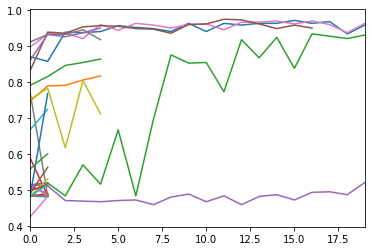

In [12]:
# Plot experiments
ax = None
for d in dfs.values():
    ax = d.mean_accuracy.plot(ax=ax, legend=False)


## Training

Now we will use the best hyperparameters we found to train the model on both the train and dev sets (since we are done tuning the model, the dev set has no purpose).

In [13]:
MODELS_PATH = "/path/to/wintics/models"

def train_model(epochs, train_data, test_data, config):
    """Trains a model on a given training dataset with a given set of hyperparameters.

    Args:
        epochs: The duration of the training in epochs.
        train_data: The data on which the model will be trained on.
        config: A dictionary that maps hyperparameter names to their values.

    Returns:
        model: The trained model.
        logs: A dictionary that contains the logs of train accuracies, dev accuracies and losses for each epoch.
    """
    losses = []
    train_accuracies = []
    test_accuracies = []
    
    # Instantiate the model
    model = DeepPool(n_conv=config['n_conv'], n_fc=config['n_fc'])
    
    # Get the data loaders for the train data
    train_loader = get_dataloader(train_dataset, batch_size=int(config['batch_size']))
    test_loader = get_dataloader(test_dataset, batch_size=int(config['batch_size']))
    
    # Define the loss function and the optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config['lr'], eps=config['eps'])

    # Begin training
    for epoch in range(epochs):
        # Train the model for this epoch
        loss = train_epoch(model, loss_fn, optimizer, train_loader)
  
        # Calculate the model's accuracies for this epoch
        train_accuracy = evaluate_accuracy(model, train_loader)
        test_accuracy = evaluate_accuracy(model, test_loader)
        
        # Log key metrics
        losses.append(loss)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        
        # Print the loss and the train and dev set accuracies
        print("epoch %d: loss: %.3f, train_acc: %.2f, test_acc: %.2f" % (epoch + 1,
                                                                         loss, train_accuracy, test_accuracy))
        
        # Save the model every 10 epochs
        if (epoch + 1) % 10 == 0:
            torch.save(model.state_dict(), os.path.join(MODELS_PATH,
                                                        "deep_pool" + str(epoch + 1)))
    
    # Insert the logs into a log object
    logs = {'train_accuracies': train_accuracies,
            'test_accuracies': test_accuracies,
            'losses': losses}
    
    print('Finished Training')
    return model, logs


In [20]:
import itertools

# model, logs = train_model(150, itertools.chain(train_dataset, dev_dataset), test_dataset, best_config)
model = DeepPool(n_conv=32, n_fc=256)
model.load_state_dict(torch.load(os.path.join(MODELS_PATH, "deep_pool150")))
model.eval()

DeepPool(
  (conv_11): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool_1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batch_norm2d_1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2d_1): Dropout2d(p=0.5, inplace=False)
  (conv_21): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_22): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (batch_norm2d_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2d_2): Dropout2d(p=0.5, inplace=False)
  (fc_1): Linear(in_features=10816, out_features=256, bias=True)
  (batch_norm_1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout_1): Dropout(p=0.5, inpl

## Evaluating

Now that we have trained a model, we just need to evaluate its performance on the test set and see which types of mistake it makes. First, let's define a function to display an image from our test set.

In [48]:
evaluate_accuracy(model, get_dataloader(test_dataset))

0.965964343598055

In [21]:
def show(img):
    """Shows an image in tensor encoding.
    
    Args:
        img: The tensor of the image to be shown
    """
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')


Now, let's show 16 images in which the classifier made a mistake in the test set.

['pool', 'no_pool', 'pool', 'pool', 'no_pool', 'pool', 'pool', 'pool', 'no_pool', 'pool', 'no_pool', 'pool', 'pool', 'pool', 'pool', 'no_pool']


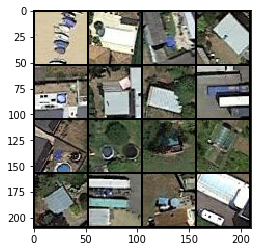

In [22]:
def show_errors(model):
    """Shows a grid of 16 mistakes the model makes in the test set and their labels.

    Args:
        model: The evaluated model.
    """
    error_images = []
    error_labels = []

    model.eval()
    with torch.no_grad():
        # Go through the test set finding errors until 16 errors are collected
        for images, labels in get_dataloader(test_dataset):
            predicted = model(images)
            _, predicted = torch.max(predicted.data, 1)
        
            for i in range(len(predicted)):
                if len(error_images) < 16 and predicted[i] != labels[i]:
                    denormalized = transforms.functional.normalize(images[i],
                                                                   (-data_mean / data_std).tolist(),
                                                                   (1.0 / data_std).tolist())
                    denormalized.clamp_(0, 1)
                    
                    error_images.append(denormalized)
                    error_labels.append(classes[labels[i]])
            
            if len(error_images) == 16:
                break
    
    show(torchvision.utils.make_grid(error_images, nrow=4))
    print(error_labels)

show_errors(model)

## Detecting Pools

Now that we have a binary classifier for the patches of satellite images, we will process and entire image using a sliding window approach. We will also use non-maximum suppression to eliminate boxes intersecting boxes.

In [23]:
def iou(box1, box2):
    """Returns the intersection-over-union of two 50x50 boxes.

    Args:
        box1: A tuple containing coordinates of the upper left corner of the first box.
        box2: A tuple containing coordinates of the upper left corner of the second box.
        
    Returns:
        float: The IoU of the two boxes.
    """
    size = 50
    
    x1, y1 = box1
    x2, y2 = box2
    
    w = max(0.0, min(x1 + size, x2 + size) - max(x1, x2))
    h = max(0.0, min(y1 + size, y2 + size) - max(y1, y2))
    intersection = w * h
    
    union = 2 * size * size - intersection
    
    return float(intersection / union)
    

In [24]:
def non_max_supression(scored_boxes, threshold):
    """Returns the result of non-maximum suppresion on a list of scored boxes.

    Args:
        scored_boxes: A tuple containing first the score, then the coordinates of the box's upper left corner
                      for each box.
        threshold: The threshold for elimination.
        
    Returns:
        list: A list of the remaining boxes.
    """
    ordered = sorted(scored_boxes, reverse=True)

    keep = []
    while len(ordered) > 0:
        score, box = ordered[0]
        keep.append(box)
        
        new_ordered = []
        for i in range(1, len(ordered)):
            if iou(box, ordered[i][1]) <= threshold:
                new_ordered.append(ordered[i])
        ordered = new_ordered

    return keep


In [26]:
from skimage import io, transform

ZONE_IMAGE_PATH = "/Users/mmcenta/Documents/wintics/zones/"

def process_zone(image_filename, stride, confidence_threshold):
    """Process a satellite image and return its pools.

    Args:
        image_filename: The filename of the zone image.
        stride: The number of pixels skipped between patches.
        confidence_threshold: The minimum confidence to classify a pool.
        
    Returns:
        list: A list of the upper left corners of the selected pools.
    """
    # Read zone image and turn it into a tensor
    zone = io.imread(os.path.join(ZONE_IMAGE_PATH, image_filename))
    zone = transforms.functional.to_tensor(zone)
    _, height, width = zone.size()
    
    # Preprocesses the image so it matches our expected input
    normalized_zone = transforms.functional.normalize(zone, mean=data_mean, std=data_std)
    
    # Extract patches from the zone
    patch_size = 50
    patches = []
    for y in range(0, height - patch_size + 1, stride):
        for x in range(0, width - patch_size + 1, stride):
            patch = normalized_zone[None, :, y:y + patch_size, x:x + patch_size]
            patches.append(patch)
    
    # Evaluate batch and gather positive results
    width_patches = 1 + (width - patch_size) // stride
    scored_pools = []
    model.eval()
    with torch.no_grad():
        batched_patches = torch.cat(patches)
        output = model(batched_patches)
        scores = torch.nn.functional.softmax(output, dim=1)[:,1]
        for k in range(len(scores)):
            if scores[k] > confidence_threshold:
                i = k % width_patches
                j = k // width_patches
                scored_pools.append((scores[k], (i * stride, j * stride)))
                
    # Execute the non-maximum supression on the boxes
    pools = non_max_supression(scored_pools, 0.1)
    
    return pools


Notice that the confidence threshold allows us to control precision-recall tradeoffs. Now a couple of functions to get the centers of the pool and show the images with their boxes are all we need to conclude our prototype.

In [32]:
def get_centers(pools):
    """Given a list of upper left corners of pools, get their centers.
    
        Args:
            pools: A list of coordinates of the upper left corners of pools.
            
        Returns:
            list: The list of coordinates of the centers of the same pools.
    """
    centers = []
    patch_size = 50
    for x, y in pools:
        centers.append((x + patch_size // 2, y + patch_size // 2))
    return centers


The cell below shows the predicted bounding boxes against the zone images. Feel free to change the filename to try out different zones.

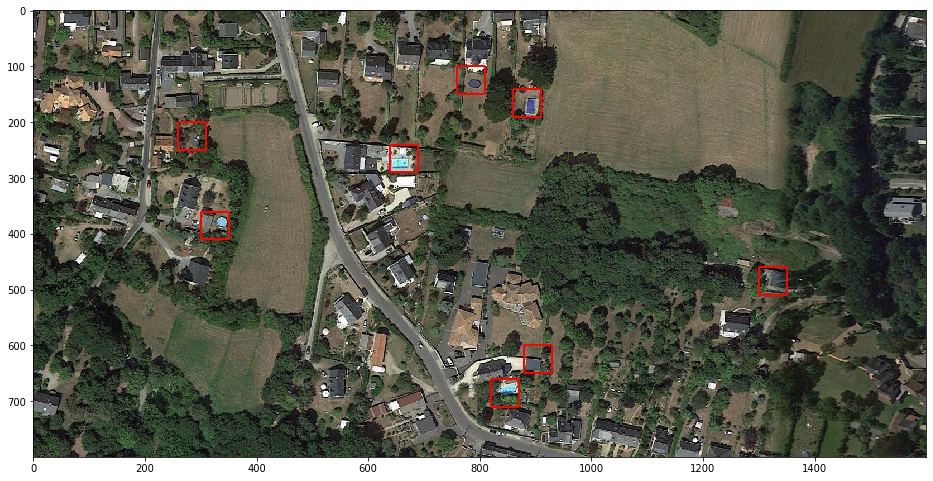

In [53]:
from matplotlib import collections as mc


RESULTS_PATH = "/path/to/wintics/results"


def show_bounding_boxes(zone_filename, pools):
    """Given a zone filename print the image with the boxes.

    Args:
        zone_filename: The filename of the zone image.
    """
    zone = io.imread(os.path.join(ZONE_IMAGE_PATH, zone_filename))
    zone = transforms.functional.to_tensor(zone)
    
    pools = process_zone(zone_filename, 20, 0.9)
    
    # Calculate the line segments of the bounding boxes
    lines = []
    patch_size = 50
    for x, y in pools:
        lines.extend([
            [(x, y), (x, y + patch_size)],
            [(x, y + patch_size), (x + patch_size, y + patch_size)],
            [(x + patch_size, y + patch_size), (x + patch_size, y)],
            [(x + patch_size, y), (x, y)]])
    
    
    lc = mc.LineCollection(lines, colors='r', linewidths=2)
    fig, ax = plt.subplots(figsize=(16.0, 10.0))
    show(zone)
    ax.add_collection(lc)
    plt.savefig(os.path.join(RESULTS_PATH, "marked_" + zone_filename))
        
show_bounding_boxes('zone5.jpg', pools)

In [52]:
# Process all zones

with open(os.path.join(RESULTS_PATH, "detection_results.txt"), 'w', encoding="utf-8") as f:
    for i in range(1, 31):
        filename = "zone" + str(i) + ".jpg"
        pools = process_zone(filename, 20, 0.9)
        pool_centers = get_centers(pools)
        f.write(filename + ": " + str(pool_centers) + '\n')


And this is the end of this notebook. Hope you liked it!